In [1]:
# Libraries

import json
import numpy
import os
import shutil

In [2]:
# Tune

from ray.air                  import RunConfig
from ray.tune                 import JupyterNotebookReporter
from ray.tune                 import TuneConfig
from ray.tune                 import Tuner
from ray.tune.logger          import CSVLoggerCallback
from ray.tune.schedulers      import ASHAScheduler
from ray.tune.search          import ConcurrencyLimiter
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search.hyperopt import HyperOptSearch

from ray import tune

In [3]:
# Code

from src.cnn import raytune as cnn_raytune
from src.cnn import core    as cnn_core
from src.io  import loader  as data_loader

# 1. Setup

In [4]:
# Setup some directory paths.

OUT_SUBFOLDER = 'nbp06-tuner'
RES_SUBFOLDER = ''

CWD = os.getcwd()
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_DATA  = os.path.join(OUT, 'data',  OUT_SUBFOLDER)
RES_NBP04 = os.path.join(OUT, 'data', 'nbp04-feature')
RES_NBP05 = os.path.join(OUT, 'data', 'nbp05-target')

shutil.rmtree(OUT_DATA, ignore_errors = True)
os.makedirs(OUT_DATA, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res


In [5]:
# System and device

DEVICE = cnn_core.get_device(only_cpu = False)
SYSTEM = cnn_core.get_system_info()

print(json.dumps(SYSTEM, indent = '\t'))

{
	"platform_system": "Windows",
	"platform_release": "10",
	"platform_version": "10.0.19044",
	"cpu_count": 12,
	"gpu_count": 1
}


In [6]:
# Lock random

RANDOM_SEED = cnn_core.lock_random(
	generate_seed = True
)

print('Random seed : {}'.format(RANDOM_SEED))

Random seed : 453642833


In [7]:
# Load the inputs and ouputs

tpm_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-order.json')
)

# 2. CNN Regression

## 2.1 Config

In [8]:
# Define basic data parameters

core_config = {
	'random_seed' : RANDOM_SEED,
	'device'      : DEVICE,
	'model_name'  : 'zrimec2020r',
	'epochs'      : 10,
	'expand_dims' : None,

	'split_size' : {
		'valid' : 0.2,
		'test'  : 0.2
	},
	'input' : {
		'channels' : 1,
		'height'   : 4,
		'width'    : 2150,
		'features' : 64
	},
	'output' : {
		'group0' : 'tissue',
		'group1' : 'tissue-mean',
		'length' : 8
	},
	'files' : {
		'sequences' : lambda : data_loader.load_fasta(filename = os.path.join(RES_NBP04, 'features-bp2150.fasta'), to_string = True),
		'frequency' : lambda : data_loader.load_npz(filename = os.path.join(RES_NBP04, 'features-frequency.npz')),
		'stability' : lambda : data_loader.load_npz(filename = os.path.join(RES_NBP04, 'features-stability.npz')),
		'values'    : lambda : data_loader.load_labels(filename = os.path.join(RES_NBP05, 'target-values.json'), to_numpy = True),
		'order'     : lambda : data_loader.load_labels(filename = os.path.join(RES_NBP05, 'target-order.json'))
	}
}

In [9]:
# Ensure correct

core_config['output']['length'] = len(tpm_order[core_config['output']['group0']])

if core_config['model_name'].startswith('washburn2019') :
	core_config['expand_dims'] = 0

## 2.2 Search Space

In [10]:
# Define possible values

batch_size = [32, 64, 128]

lr       = [1e-2, 1e-3, 1e-4, 1e-5] # learning rate
decay    = [0.00, 1e-1, 1e-2, 1e-3] # adam weight decay
momentum = [0.90, 0.95, 0.97, 0.99] # adam momentum low bound (high = 0.999)

dropout = [0.1, 0.2, 0.3, 0.4, 0.5]

conv1_kernels  = [5, 11, 21, 31, 41]
conv1_filters  = [32, 64, 128, 256]

convx_kernels  = [5, 11, 21, 31, 41]
convx_padding  = ['same', 'none']
convx_filters  = [32, 64, 128, 256]
convx_dilation = [1, 2, 4]
poolx_kernels  = [3, 5, 9]

fc_features = [64, 128, 256, 512]

In [11]:
# Extends to 2D models

if core_config['model_name'].startswith('washburn2019') :
	conv1_kernels = [(4, x) for x in conv1_kernels]
	convx_kernels = [(1, x) for x in convx_kernels]
	poolx_kernels = [(1, x) for x in poolx_kernels]

In [12]:
# Define search space (tested with zrimec2020 and washburn2019)

param_space = dict()
param_space['dataset/batch_size']  = tune.choice(batch_size)
param_space['optimizer/lr']        = tune.choice(lr)
param_space['optimizer/decay']     = tune.choice(decay)
param_space['optimizer/momentum']  = tune.choice(momentum)
param_space['model/dropout']       = tune.choice(dropout)

# Convolutions
param_space['model/conv1/filters'] = tune.choice(conv1_filters)
param_space['model/conv1/kernel']  = tune.choice(conv1_kernels)
param_space['model/conv1/padding'] = 'none'
param_space['model/conv2/filters'] = tune.choice(convx_filters)
param_space['model/conv2/kernel']  = tune.choice(convx_kernels)
param_space['model/conv2/padding'] = tune.choice(convx_padding)
param_space['model/conv3/filters'] = tune.choice(convx_filters)
param_space['model/conv3/kernel']  = tune.choice(convx_kernels)
param_space['model/conv3/padding'] = tune.choice(convx_padding)

if core_config['model_name'].startswith('washburn2019') :
	param_space['model/conv4/filters'] = tune.choice(convx_filters)
	param_space['model/conv4/kernel']  = tune.choice(convx_kernels)
	param_space['model/conv4/padding'] = tune.choice(convx_padding)
	param_space['model/conv5/filters'] = tune.choice(convx_filters)
	param_space['model/conv5/kernel']  = tune.choice(convx_kernels)
	param_space['model/conv5/padding'] = tune.choice(convx_padding)
	param_space['model/conv6/filters'] = tune.choice(convx_filters)
	param_space['model/conv6/kernel']  = tune.choice(convx_kernels)
	param_space['model/conv6/padding'] = tune.choice(convx_padding)

# Pooling
param_space['model/maxpool1/kernel']  = tune.choice(poolx_kernels)
param_space['model/maxpool1/padding'] = 'same'
param_space['model/maxpool2/kernel']  = tune.choice(poolx_kernels)
param_space['model/maxpool2/padding'] = 'same'
param_space['model/maxpool3/kernel']  = tune.choice(poolx_kernels)
param_space['model/maxpool3/padding'] = 'same'

# Linear
param_space['model/fc1/features'] = tune.choice(fc_features)
param_space['model/fc2/features'] = tune.choice(fc_features)

In [13]:
# Define starting parameters for algorithm (some decent starting point from previous runs)

params_initial = None

if core_config['model_name'].startswith('zrimec2020') :
	params_initial = [{
		'dataset/batch_size'     : 32,
		'optimizer/lr'           : 0.0001,
		'optimizer/decay'        : 0.1,
		'optimizer/momentum'     : 0.99,
		'model/dropout'          : 0.1,
		'model/conv1/filters'    : 32,
		'model/conv1/kernel'     : 21,
		'model/conv1/padding'    : 'none',
		'model/conv2/filters'    : 256,
		'model/conv2/kernel'     : 31,
		'model/conv2/padding'    : 'same',
		'model/conv3/filters'    : 32,
		'model/conv3/kernel'     : 5,
		'model/conv3/padding'    : 'none',
		'model/maxpool1/kernel'  : 3,
		'model/maxpool1/padding' : 'same',
		'model/maxpool2/kernel'  : 9,
		'model/maxpool2/padding' : 'same',
		'model/maxpool3/kernel'  : 3,
		'model/maxpool3/padding' : 'same',
		'model/fc1/features'     : 256,
		'model/fc2/features'     : 128
	}]

## 2.3 Tuning

In [14]:
# Verbosity levels as specified by raytune

VERBOSE_SILENT = 0
VERBOSE_STATUS = 1
VERBOSE_BRIEF  = 2
VERBOSE_DETAIL = 3

In [15]:
# Create a hyperparameter optimization tuner

tune_method = tune.with_resources(
	lambda x : cnn_raytune.tune_method(
		tune_config = x,
		core_config = core_config
	),
	{
		'cpu' : max(1, SYSTEM['cpu_count'] // 2),
		'gpu' : max(0, SYSTEM['gpu_count'])
	}
)

tune_config = TuneConfig(
	metric      = 'valid_loss',
	mode        = 'min',
	num_samples = 20,
	search_alg  = ConcurrencyLimiter(
		searcher = HyperOptSearch(
			points_to_evaluate = params_initial,
			metric             = 'valid_loss',
			mode               = 'min'
		),
		max_concurrent = 1
	),
	scheduler = ASHAScheduler(
		time_attr        = 'training_iteration',
		max_t            = 50,
		grace_period     = 2,
		reduction_factor = 4,
		brackets         = 1
		
	),
	trial_name_creator    = lambda x : str(x.trial_id),
	trial_dirname_creator = lambda x : str(x.trial_id)
)

run_config = RunConfig(
	name              = core_config['model_name'],
	local_dir         = OUT_DATA,
	callbacks         = None,
	log_to_file       = True,
	verbose           = VERBOSE_STATUS,
	progress_reporter = JupyterNotebookReporter(
		max_column_length = 32,
		max_progress_rows = 20,
		parameter_columns = ['dataset/batch_size', 'optimizer/lr', 'optimizer/decay', 'optimizer/momentum'],
		metric_columns    = ['valid_loss', 'valid_r2']
	)
)

tuner = Tuner(
	trainable   = tune_method,
	tune_config = tune_config,
	run_config  = run_config,
	param_space = param_space
)

report = tuner.fit()

2023-01-31 15:10:15,920	INFO worker.py:1538 -- Started a local Ray instance.
2023-01-31 17:10:13,191	INFO tune.py:762 -- Total run time: 7194.29 seconds (7193.81 seconds for the tuning loop).


## 2.4 Reports

In [16]:
# Check if there have been errors

if report.errors :
	print('At least one of the trials has failed.')
else :
	print('No errors.')

No errors.


In [17]:
# Print the results as dataframe

dataframe = report.get_dataframe()

print('Shortest training time : {:.2f} seconds'.format(dataframe['time_total_s'].min()))
print(' Longest training time : {:.2f} seconds'.format(dataframe['time_total_s'].max()))
print()

trials = dataframe[['trial_id', 'logdir', 'time_total_s', 'training_iteration', 'valid_loss', 'valid_r2', 'valid_mae', 'train_loss']]
trials

Shortest training time : 87.04 seconds
 Longest training time : 1755.12 seconds



,trial_id,logdir,time_total_s,training_iteration,valid_loss,valid_r2,valid_mae,train_loss
0,97e066dd,C:\Developer\Workspace\PyCharm\Projects\upolan...,1755.116,10,0.586,0.034,0.629,0.443
1,67f07672,C:\Developer\Workspace\PyCharm\Projects\upolan...,153.993,2,2.445,-2.899,1.338,3.978
2,9033e992,C:\Developer\Workspace\PyCharm\Projects\upolan...,159.761,2,2.865,-3.656,1.480,2.810
3,8b6d0a6f,C:\Developer\Workspace\PyCharm\Projects\upolan...,138.287,2,1.989,-2.316,1.177,2.169
4,37c67a6f,C:\Developer\Workspace\PyCharm\Projects\upolan...,525.760,2,2.790,-3.445,1.464,2.780
5,9a2fbedb,C:\Developer\Workspace\PyCharm\Projects\upolan...,1061.729,8,0.868,-0.386,0.752,0.647
6,2e088e94,C:\Developer\Workspace\PyCharm\Projects\upolan...,494.512,10,0.539,0.140,0.604,0.486
7,05c9be5a,C:\Developer\Workspace\PyCharm\Projects\upolan...,512.853,2,2.349,-2.808,1.313,2.179
8,ed77ce7a,C:\Developer\Workspace\PyCharm\Projects\upolan...,110.756,2,2.042,-2.352,1.192,2.090
9,08734158,C:\Developer\Workspace\PyCharm\Projects\upolan...,219.822,2,2.791,-3.647,1.464,2.782


### 2.4.1 VIsualization

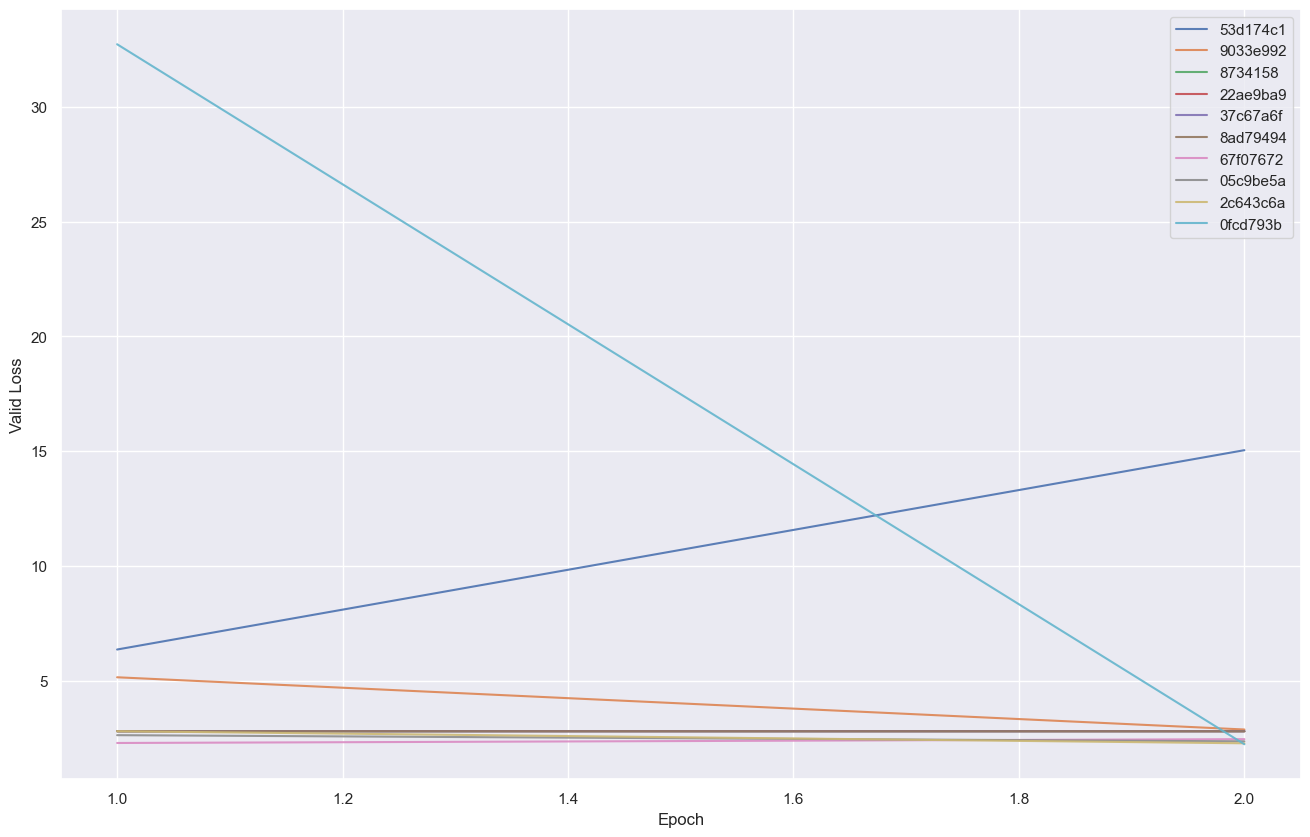

In [18]:
# Plot trials valid loss

cnn_raytune.plot_trials_loss(
	dataframe  = trials,
	max_trials = 10,
	alpha      = 0.9,
	filename   = os.path.join(OUT_DATA, core_config['model_name'] + '-trials')
)

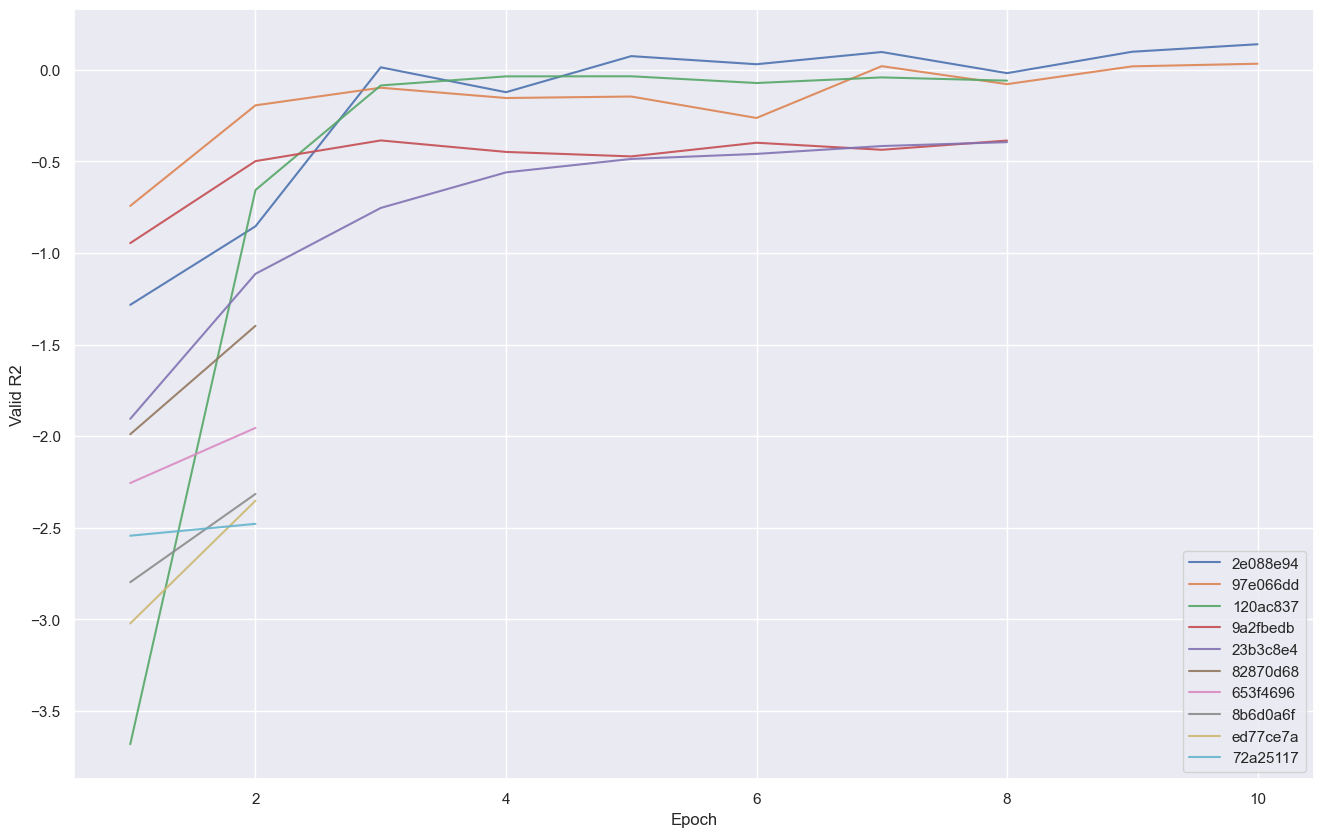

In [19]:
# Plot trials valid r2

cnn_raytune.plot_trials_r2(
	dataframe  = trials,
	max_trials = 10,
	alpha      = 0.9,
	filename   = os.path.join(OUT_DATA, core_config['model_name'] + '-trials')
)

### 2.4.2 Best

In [20]:
# Display best trial

best = report.get_best_result()

print('Best metric : loss = {: 8.5f} r2 = {: 8.5f}'.format(best.metrics['valid_loss'], best.metrics['valid_r2']))
print('Best config : ')
print(json.dumps(best.config, indent = '\t'))

Best metric : loss =  0.53905 r2 =  0.14027
Best config : 
{
	"dataset/batch_size": 64,
	"optimizer/lr": 0.001,
	"optimizer/decay": 0.01,
	"optimizer/momentum": 0.97,
	"model/dropout": 0.1,
	"model/conv1/filters": 64,
	"model/conv1/kernel": 21,
	"model/conv1/padding": "none",
	"model/conv2/filters": 64,
	"model/conv2/kernel": 31,
	"model/conv2/padding": "none",
	"model/conv3/filters": 128,
	"model/conv3/kernel": 5,
	"model/conv3/padding": "same",
	"model/maxpool1/kernel": 9,
	"model/maxpool1/padding": "same",
	"model/maxpool2/kernel": 3,
	"model/maxpool2/padding": "same",
	"model/maxpool3/kernel": 3,
	"model/maxpool3/padding": "same",
	"model/fc1/features": 128,
	"model/fc2/features": 256
}


In [21]:
# Display per iteration

progress = data_loader.load_csv(
	filename = os.path.join(best.log_dir, 'progress.csv')
)

progress = progress[['trial_id', 'experiment_id', 'time_total_s', 'training_iteration', 'valid_loss', 'valid_r2', 'valid_mae', 'train_loss']]
progress

,trial_id,experiment_id,time_total_s,training_iteration,valid_loss,valid_r2,valid_mae,train_loss
0,2e088e94,18e20048777c45af81834d57bbb8ef9e,85.183,1,1.408,-1.283,0.948,1.184
1,2e088e94,18e20048777c45af81834d57bbb8ef9e,129.253,2,1.131,-0.854,0.849,1.035
2,2e088e94,18e20048777c45af81834d57bbb8ef9e,173.787,3,0.617,0.014,0.648,0.712
3,2e088e94,18e20048777c45af81834d57bbb8ef9e,218.439,4,0.696,-0.122,0.674,0.547
4,2e088e94,18e20048777c45af81834d57bbb8ef9e,264.868,5,0.577,0.075,0.628,0.528
5,2e088e94,18e20048777c45af81834d57bbb8ef9e,309.454,6,0.600,0.031,0.634,0.519
6,2e088e94,18e20048777c45af81834d57bbb8ef9e,355.112,7,0.561,0.098,0.616,0.505
7,2e088e94,18e20048777c45af81834d57bbb8ef9e,402.435,8,0.635,-0.018,0.647,0.496
8,2e088e94,18e20048777c45af81834d57bbb8ef9e,448.221,9,0.558,0.099,0.610,0.488
9,2e088e94,18e20048777c45af81834d57bbb8ef9e,494.512,10,0.539,0.140,0.604,0.486


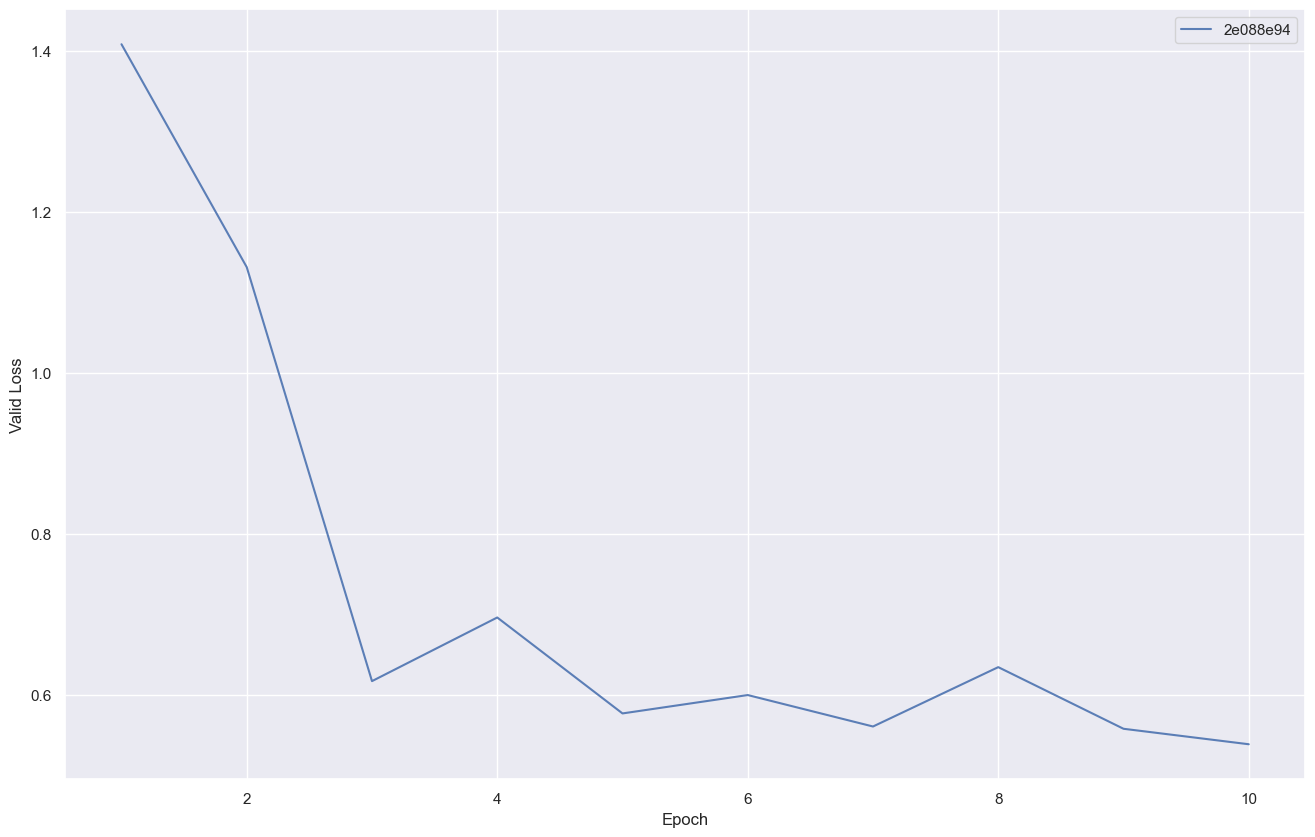

In [22]:
# Plot best trial valid loss

cnn_raytune.plot_trial_loss(
	dataframe = progress,
	filename  = os.path.join(OUT_DATA, core_config['model_name'] + '-best')
)

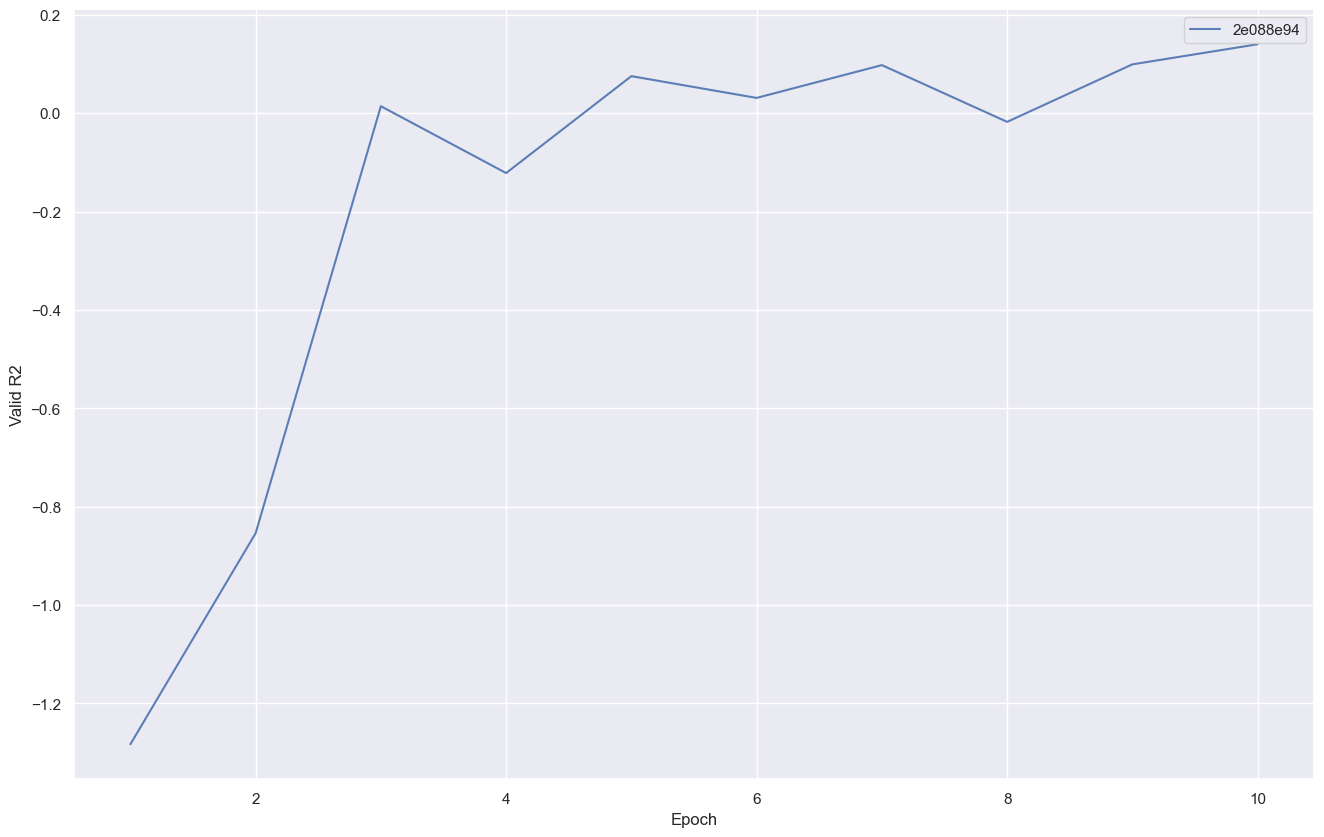

In [23]:
# Plot best trial valid r2

cnn_raytune.plot_trial_r2(
	dataframe = progress,
	filename  = os.path.join(OUT_DATA, core_config['model_name'] + '-best')
)

### 2.4.3 Worst

In [24]:
# Display worst trial

worst = report.get_best_result(metric = 'valid_loss', mode = 'max')

print('Worst metric : loss = {: 8.5f} r2 = {: 8.5f}'.format(worst.metrics['valid_loss'], worst.metrics['valid_r2']))
print('Worst config : ')
print(json.dumps(worst.config, indent = '\t'))

Worst metric : loss =  15.03636 r2 = -23.17345
Worst config : 
{
	"dataset/batch_size": 128,
	"optimizer/lr": 0.001,
	"optimizer/decay": 0.01,
	"optimizer/momentum": 0.99,
	"model/dropout": 0.2,
	"model/conv1/filters": 128,
	"model/conv1/kernel": 31,
	"model/conv1/padding": "none",
	"model/conv2/filters": 32,
	"model/conv2/kernel": 31,
	"model/conv2/padding": "same",
	"model/conv3/filters": 32,
	"model/conv3/kernel": 11,
	"model/conv3/padding": "none",
	"model/maxpool1/kernel": 5,
	"model/maxpool1/padding": "same",
	"model/maxpool2/kernel": 9,
	"model/maxpool2/padding": "same",
	"model/maxpool3/kernel": 5,
	"model/maxpool3/padding": "same",
	"model/fc1/features": 128,
	"model/fc2/features": 512
}


In [25]:
# Display per iteration

progress = data_loader.load_csv(
	filename = os.path.join(worst.log_dir, 'progress.csv')
)

progress = progress[['trial_id', 'experiment_id', 'time_total_s', 'training_iteration', 'valid_loss', 'valid_r2', 'valid_mae', 'train_loss']]
progress

,trial_id,experiment_id,time_total_s,training_iteration,valid_loss,valid_r2,valid_mae,train_loss
0,53d174c1,1325b2ba623a4693b930c7d388fe19ad,83.422,1,6.351,-9.280,1.704,1.386
1,53d174c1,1325b2ba623a4693b930c7d388fe19ad,124.152,2,15.036,-23.173,2.486,1.159


## 2.5 Save

In [26]:
# Save the tuning results

report.get_dataframe().to_csv(
	os.path.join(OUT_DATA, core_config['model_name'] + '-report.csv')
)